In [8]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision

data_root = 'C:/Users/Ильнар/Conda/Kaggle соревнования/plates'
os.listdir(data_root)

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 88.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


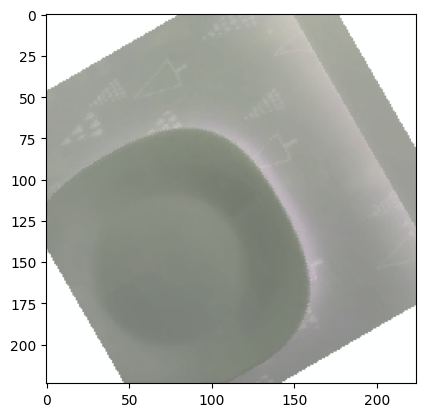

In [9]:
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

import time
import copy

from torchvision import transforms, models

train_transformer = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomAffine(degrees=(120, 120)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_data = torchvision.datasets.ImageFolder(train_dir,train_transformer)
val_data = torchvision.datasets.ImageFolder(val_dir,val_transformer)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=batch_size)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);



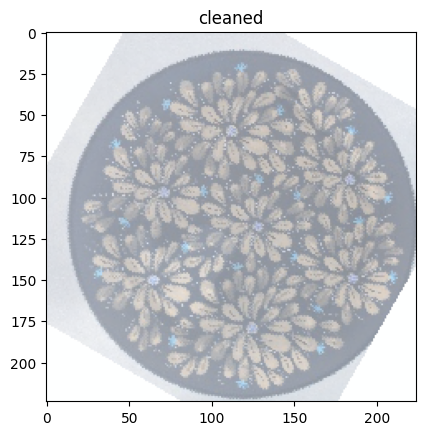

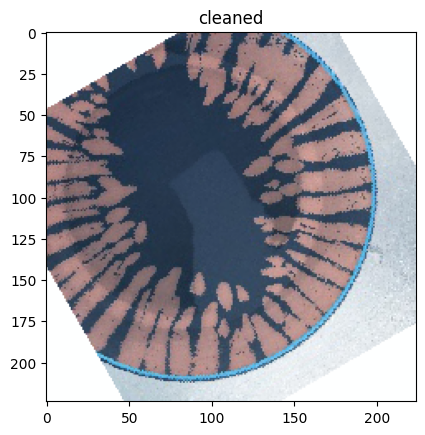

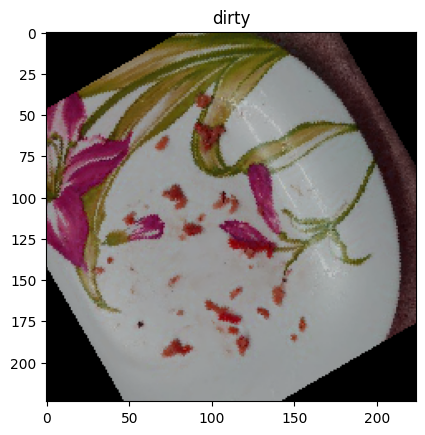

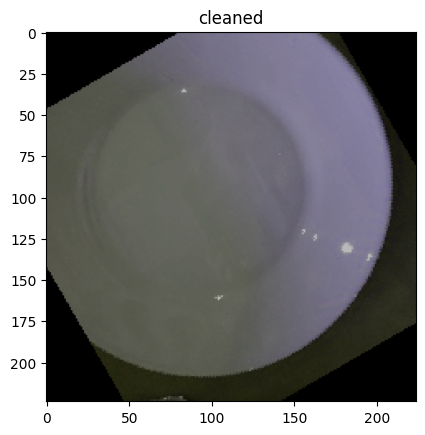

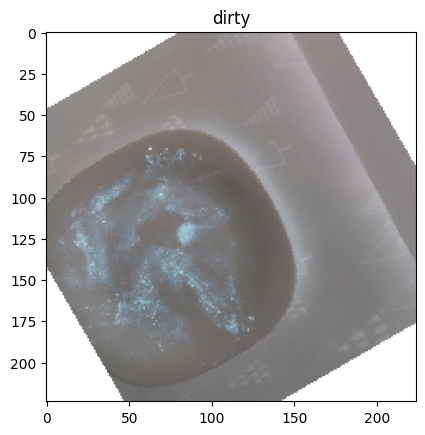

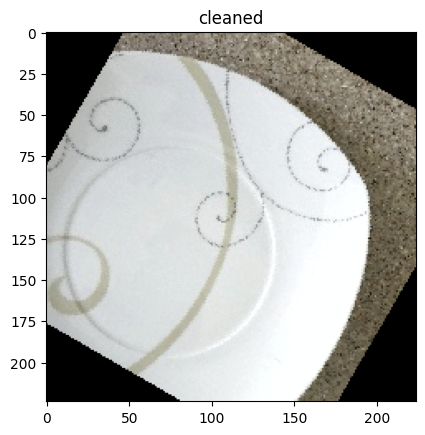

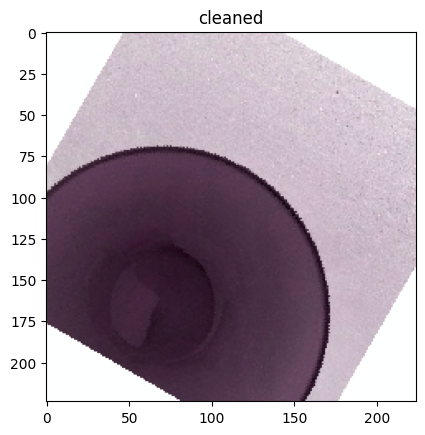

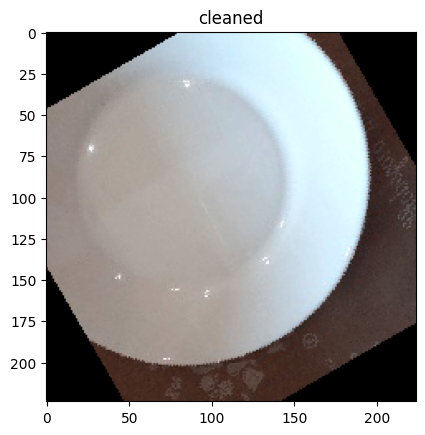

In [10]:
def show_input(input_tensor,title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0,1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])



In [11]:
model = models.resnet101(pretrained=True)

def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train','val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
                
            else:
                
                dataloader = val_dataloader
                model.eval()
            
            running_loss = 0
            running_acc = 0
            
            for inputs,labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_val = loss(preds,labels)
                    pred_class = preds.argmax(dim=1)
                    
                    if phase=='train':
                        loss_val.backward()
                        optimizer.step()
                        
                running_loss += loss_val.item()
                running_acc += (pred_class == labels.data).float().mean()
                    
                    
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
    return model

for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

train_model(model, loss, optimizer, scheduler, num_epochs=50)



C:\Users\Ильнар\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ильнар\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Ильнар/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:15<00:00, 11.5MB/s]


Epoch 0/49:


C:\Users\Ильнар\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]

train Loss: 0.7928 Acc: 0.5000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]

val Loss: 0.9141 Acc: 0.5000
Epoch 1/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.6495 Acc: 0.5500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]

val Loss: 0.7173 Acc: 0.5000
Epoch 2/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.7967 Acc: 0.4500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]

val Loss: 0.7495 Acc: 0.5000
Epoch 3/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.7996 Acc: 0.5500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]

val Loss: 1.0245 Acc: 0.5000
Epoch 4/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.6778 Acc: 0.4750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]

val Loss: 0.6568 Acc: 0.6667
Epoch 5/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]

train Loss: 1.0822 Acc: 0.5250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]

val Loss: 0.8571 Acc: 0.5000
Epoch 6/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]

train Loss: 0.7984 Acc: 0.5250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.87s/it]

val Loss: 0.8729 Acc: 0.5000
Epoch 7/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.52s/it]

train Loss: 0.8042 Acc: 0.5750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.03s/it]

val Loss: 0.6296 Acc: 0.6667
Epoch 8/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.71s/it]

train Loss: 0.6200 Acc: 0.6000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]

val Loss: 0.7073 Acc: 0.6667
Epoch 9/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.5798 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]

val Loss: 0.6404 Acc: 0.6667
Epoch 10/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]

train Loss: 0.5927 Acc: 0.6500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.61s/it]

val Loss: 0.6482 Acc: 0.6667
Epoch 11/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.6621 Acc: 0.5500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]

val Loss: 0.5287 Acc: 0.8333
Epoch 12/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.61s/it]

train Loss: 0.4389 Acc: 0.8250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.83s/it]

val Loss: 0.6720 Acc: 0.6667
Epoch 13/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.55s/it]

train Loss: 0.5338 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.71s/it]

val Loss: 0.5645 Acc: 0.6667
Epoch 14/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.61s/it]

train Loss: 0.5110 Acc: 0.8250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]

val Loss: 0.5338 Acc: 0.6667
Epoch 15/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.3826 Acc: 0.8000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]

val Loss: 0.5318 Acc: 0.8333
Epoch 16/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.5417 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]

val Loss: 0.5448 Acc: 0.6667
Epoch 17/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]

train Loss: 0.4107 Acc: 0.8250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]

val Loss: 0.4837 Acc: 0.6667
Epoch 18/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.4242 Acc: 0.8500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.98s/it]

val Loss: 0.4840 Acc: 0.6667
Epoch 19/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.4270 Acc: 0.8500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]

val Loss: 0.5411 Acc: 0.6667
Epoch 20/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]

train Loss: 0.5820 Acc: 0.6500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]

val Loss: 0.5229 Acc: 0.6667
Epoch 21/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.3928 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]

val Loss: 0.4701 Acc: 0.8333
Epoch 22/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.55s/it]

train Loss: 0.5302 Acc: 0.6750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]

val Loss: 0.4759 Acc: 0.6667
Epoch 23/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.60s/it]

train Loss: 0.4032 Acc: 0.7750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]

val Loss: 0.5759 Acc: 0.6667
Epoch 24/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]

train Loss: 0.3741 Acc: 0.8250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]

val Loss: 0.4610 Acc: 0.6667
Epoch 25/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]

train Loss: 0.4562 Acc: 0.7500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]

val Loss: 0.4280 Acc: 0.8333
Epoch 26/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.4571 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]

val Loss: 0.4381 Acc: 0.6667
Epoch 27/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.4245 Acc: 0.7750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.84s/it]

val Loss: 0.4193 Acc: 0.6667
Epoch 28/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.4160 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]

val Loss: 0.4320 Acc: 0.6667
Epoch 29/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.4690 Acc: 0.7750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.86s/it]

val Loss: 0.4155 Acc: 0.6667
Epoch 30/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.64s/it]

train Loss: 0.3154 Acc: 0.9250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]

val Loss: 0.3793 Acc: 0.8333
Epoch 31/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]

train Loss: 0.2620 Acc: 0.9500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.89s/it]

val Loss: 0.4369 Acc: 0.6667
Epoch 32/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.5678 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.89s/it]

val Loss: 0.4475 Acc: 0.6667
Epoch 33/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.3284 Acc: 0.9500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]

val Loss: 0.4939 Acc: 0.6667
Epoch 34/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]

train Loss: 0.2814 Acc: 0.9250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]

val Loss: 0.3850 Acc: 0.8333
Epoch 35/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.2815 Acc: 0.9500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]

val Loss: 0.3178 Acc: 0.8333
Epoch 36/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]

train Loss: 0.3313 Acc: 0.8500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]

val Loss: 0.3096 Acc: 0.8333
Epoch 37/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.4922 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.86s/it]

val Loss: 0.3217 Acc: 1.0000
Epoch 38/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]

train Loss: 0.4520 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.56s/it]

val Loss: 0.3754 Acc: 0.8333
Epoch 39/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]

train Loss: 0.2842 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.74s/it]

val Loss: 0.4076 Acc: 0.8333
Epoch 40/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.3078 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]

val Loss: 0.4052 Acc: 0.8333
Epoch 41/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]

train Loss: 0.4352 Acc: 0.8250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]

val Loss: 0.3767 Acc: 0.8333
Epoch 42/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.4524 Acc: 0.7250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.86s/it]

val Loss: 0.3866 Acc: 0.8333
Epoch 43/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.3195 Acc: 0.9250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.76s/it]

val Loss: 0.4347 Acc: 0.5000
Epoch 44/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.3788 Acc: 0.9250



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.76s/it]

val Loss: 0.3946 Acc: 0.6667
Epoch 45/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.61s/it]

train Loss: 0.4755 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.88s/it]

val Loss: 0.3859 Acc: 0.8333
Epoch 46/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

train Loss: 0.5909 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]

val Loss: 0.4706 Acc: 0.8333
Epoch 47/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

train Loss: 0.3606 Acc: 0.8000



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.77s/it]

val Loss: 0.4915 Acc: 0.6667
Epoch 48/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.66s/it]

train Loss: 0.4906 Acc: 0.7500



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]

val Loss: 0.5833 Acc: 0.6667
Epoch 49/49:



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]

train Loss: 0.3941 Acc: 0.7750



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.94s/it]

val Loss: 0.3338 Acc: 1.0000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transformer)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)



100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [05:46<00:00,  3.73s/it]


In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str[-5:-9:-1]
submission_df['id'] = submission_df['id'].str[-1::-1]
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')